# Deep Reinforcement Learning for Portfolio Optimization 

### Summary
This project explores the application of **Deep Deterministic Policy Gradient (DDPG)**, a continuous control Reinforcement Learning algorithm, to solve the portfolio optimization problem for South African equities.

This AI agent learns to manage a portfolio dynamically, balancing risk-adjusted returns (Sharpe Ratio) against transaction costs. 

### Technical Architecture
* **Core Algorithm:** DDPG (Actor-Critic) via `Stable-Baselines3`.
* **Environment:** Custom `Gymnasium` trading environment with:
    * **State Space:** Returns, Volatility, and Macroeconomic Indicators.
    * **Action Space:** Continuous portfolio weights.
    * **Reward Function:** Daily return less transaction costs.
* **Optimization:** Bayesian Hyperparameter Optimization using **Optuna**.
* **Validation:**
    * **Walk-Forward Analysis:** Train (70%) / Validation (10%) / Test (20%) split.
    * **Robustness Check:** 5-seed independent training loop to verify stability.
    * **Block Bootstrap:** Non-parametric statistical testing to validate performance.

### Benchmarks
The agent's performance is evaluated against three distinct strategies:
1.  **Equal Weight:** Each equity in the portfolio is given the same weight.
2.  **Inverse Volatility:** Equties are given weights according to historical volatility with more volatile stocks receiving a lower weight vice versa.
3.  **Best Single Stock:** The theoretical ceiling of a "perfect" stock pick.

---

In [ ]:
%pip install yfinance pandas numpy matplotlib gymnasium stable-baselines3 shimmy

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns 

# ensures our plots look nice
%matplotlib inline 
plt.style.use('ggplot')


### Data Pipeline & Asset Universe

I constructed a dataset of 12 JSE stocks spanning four key sectors (Banking, Retail, Mining, Energy) to enable the agent to learn diverse rotation strategies. To provide global market context, I included macro indicators: USD/ZAR, Brent Crude, and the S&P 500. The stocks (see the 'TICKERS' list below) were chosen as they are good representives for their sectors (large market cap) and they have a long history of prices available on yfinance (which provides more training data for the agent).

**The Preprocessing Pipeline:**
* **Anomaly Detection:** Automated scanning for bad ticks (e.g., >90% drops), repairing errors in `PPH.JO` and `SBK.JO`.
* **Time Alignment:** merged daily closes for all assets and indicators, handling missing data via forward-filling.
* **Feature Engineering:**
    * **Log Returns:** $\ln(P_t / P_{t-1})$ for stationarity.
    * **Volatility:** 20-day rolling standard deviation to quantify recent risk.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np


TICKERS = [
    #Banking
    "FSR.JO",   # FirstRand
    "CPI.JO",   # Capitec 
    "SBK.JO",   # Standard Bank 
    
    # Retail 
    "SHP.JO",   # Shoprite 
    "PPH.JO",   # Pepkor 
    "CLS.JO",   # Clicks 
    
    # Mining 
    "AGL.JO",   # Anglo American 
    "ANG.JO",   # Anglogold Ashanti 
    "GFI.JO",   # Gold Fields 
    
    # Energy (Sasol + Coal)
    "SOL.JO",   # Sasol
    "EXX.JO",   # Exxaro 
    "GLN.JO"    # Glencore 
]
MACRO_TICKERS = {
    "USDZAR": "ZAR=X",
    "OIL": "BZ=F",
    "SP500": "^GSPC"
}

START_DATE = '2018-01-01'
END_DATE = '2026-01-21'


def get_jse_data(tickers, macro_tickers, start, end):
    print(f"Downloading {len(tickers)} assets and {len(macro_tickers)} macro indicators...")
    
    # auto_adjust=True handles dividends and stock splits automatically
    stock_data = yf.download(tickers, start=start, end=end, auto_adjust=True)
    
    # handle yfinance MultiIndex structure
    try:
        if isinstance(stock_data.columns, pd.MultiIndex) and 'Close' in stock_data.columns.levels[0]:
            df_stocks = stock_data['Close']
        else:
            df_stocks = stock_data 
    except:
        df_stocks = stock_data['Close'] if 'Close' in stock_data.columns else stock_data

    # Macro Data
    macro_data = yf.download(list(macro_tickers.values()), start=start, end=end, auto_adjust=True)
    
    try:
        if isinstance(macro_data.columns, pd.MultiIndex) and 'Close' in macro_data.columns.levels[0]:
            df_macro = macro_data['Close']
        else:
            df_macro = macro_data
    except:
        df_macro = macro_data['Close'] if 'Close' in macro_data.columns else macro_data
        
    # Rename Macro Columns
    inv_map = {v: k for k, v in macro_tickers.items()}
    df_macro = df_macro.rename(columns=inv_map)
    
    # Merge and Fill
    df_stocks = df_stocks.ffill().bfill().dropna()
    df_macro = df_macro.ffill().bfill().dropna()
    
    # Align dates
    common_index = df_stocks.index.intersection(df_macro.index)
    df_stocks = df_stocks.loc[common_index]
    df_macro = df_macro.loc[common_index]

    print(f"Data Aligned. Stocks: {df_stocks.shape}, Macro: {df_macro.shape}")
    return df_stocks, df_macro


df_stocks, df_macro = get_jse_data(TICKERS, MACRO_TICKERS, START_DATE, END_DATE)


print("Scanning stock prices for anomalies...")


# look for > 90% drop or > 1000% gain 
temp_pct_change = df_stocks.pct_change()
bad_ticks_mask = (temp_pct_change < -0.90) | (temp_pct_change > 10.0)

if bad_ticks_mask.any().any():
    print(f" DATA ANOMALY DETECTED!")
    
    # Identify which stocks are broken
    bad_counts = bad_ticks_mask.sum()
    print(bad_counts[bad_counts > 0])
    
    # Set bad prices to NaN, then Forward Fill
    df_stocks = df_stocks.mask(bad_ticks_mask, np.nan)
    df_stocks = df_stocks.ffill()
    
    print(" Raw prices fixed via Forward Fill.")
else:
    print("No anomaly found")

print("Calculating Log Returns")
stocks_ret = np.log(df_stocks / df_stocks.shift(1)).dropna()
macro_ret = np.log(df_macro / df_macro.shift(1)).dropna()


common_index = stocks_ret.index.intersection(macro_ret.index)
stocks_ret = stocks_ret.loc[common_index]
macro_ret = macro_ret.loc[common_index]


# Calculate volatility for past 20 days (first 20 days of data will be dropped)
stocks_vol = stocks_ret.rolling(window=20).std().dropna()

# Re-align the other dataframes to match this slightly shorter index
common_index = stocks_vol.index.intersection(stocks_ret.index).intersection(macro_ret.index)
stocks_ret = stocks_ret.loc[common_index]
macro_ret = macro_ret.loc[common_index]
stocks_vol = stocks_vol.loc[common_index]

print(f"\nFinal Dataset Ready.")
print(f"Stocks Shape: {stocks_ret.shape}")
print(f"Macro Shape:  {macro_ret.shape}")

[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  3 of 3 completed

Data Aligned. Stocks: (2012, 12), Macro: (2012, 3)
Scanning stock prices for anomalies...
 DATA ANOMALY DETECTED!
Ticker
PPH.JO    2
SBK.JO    2
dtype: int64
 Raw prices fixed via Forward Fill.
Calculating Log Returns

Final Dataset Ready.
Stocks Shape: (1992, 12)
Macro Shape:  (1992, 3)


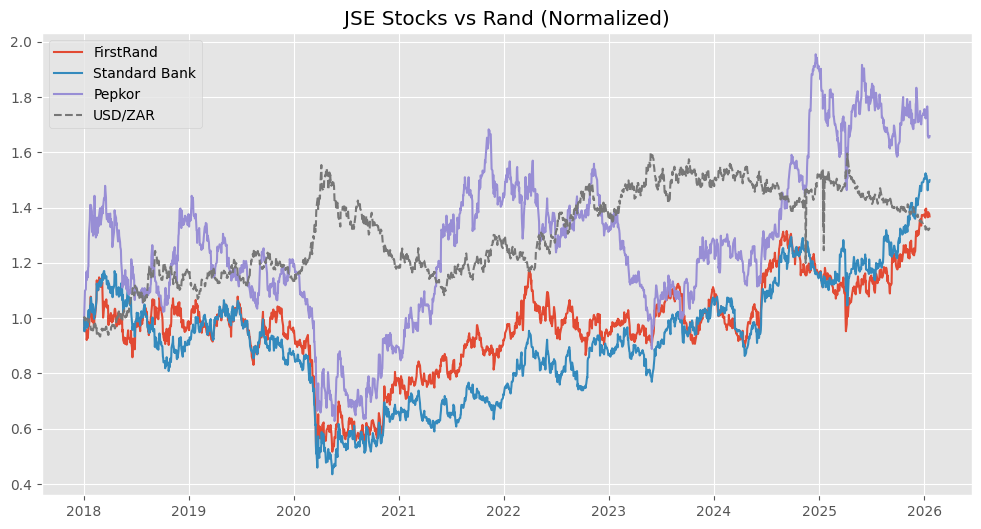

In [ ]:
# Plotting to visualize "Correlation"
# normalize (divide by the first price) so everything starts at 1.0
normalized_df = df_stocks / df_stocks.iloc[0]
normalized_macro_df = df_macro / df_macro.iloc[0]


plt.figure(figsize=(12, 6))
# Plot just a few interesting ones to avoid clutter
plt.plot(normalized_df['FSR.JO'], label='FirstRand')
plt.plot(normalized_df['SBK.JO'], label='Standard Bank')
plt.plot(normalized_df['PPH.JO'], label='Pepkor')
plt.plot(normalized_macro_df['USDZAR'], label='USD/ZAR', linestyle='--')
plt.title('JSE Stocks vs Rand (Normalized)')
plt.legend()
plt.show()

### Exploratory Data Analysis: Correlation Structure

**Key Observations:**
* **Sector Clustering (Multicollinearity):** I observe strong positive correlations (> 0.7) within sectors.
    * **Gold Miners:** `ANG` and `GFI` are highly correlated, likely driven by demand for gold. 
    * **Financials:** `FSR` and `SBK` are highly correlated.
* **Diversification Opportunities:** There is a distinct low or negative correlation between the **Mining** and **Banking** sectors.
    * *Insight:* When the local economy struggles (hurting Banks), the Rand often weakens (`USDZAR` goes up), which benefits Miners who earn in Dollars. The agent can exploit this natural hedge.
* **Redundancy Check:** High correlations suggest that some assets provide redundant state information. The agent must learn to allocate capital efficiently across these clusters rather than treating them as independent bets.

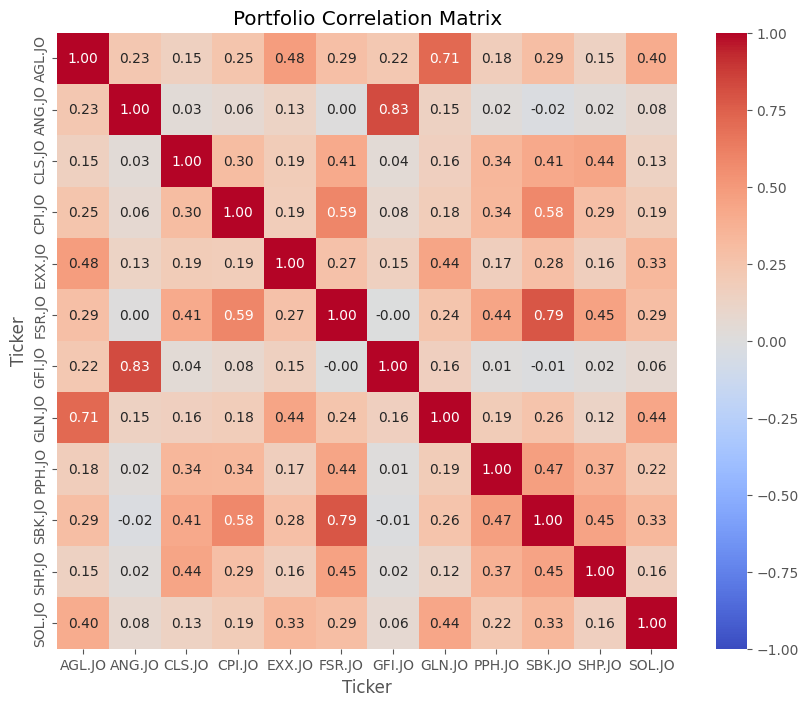

In [78]:
plt.figure(figsize=(10, 8))
correlation_matrix = stocks_ret.corr()

sns.heatmap(correlation_matrix, 
            annot=True,     
            fmt=".2f",      
            cmap='coolwarm', # Red = High Corr, Blue = Low Corr
            vmin=-1, vmax=1)

plt.title('Portfolio Correlation Matrix')
plt.show()

### Custom RL Environment 

I implemented a custom **Gymnasium** environment to simulate realistic portfolio management dynamics.

* **State Space (Dim: 255):** A rolling window of **20-day past returns**, current **volatility**, and **macro indicators** (USDZAR, Oil, S&P 500).
* **Action Space:** Continuous vector ($N=12$) transformed via **Softmax** into portfolio weights ($\sum w_i = 1$).
* **Reward Function:** Log-returns adjusted for transaction costs to penalize churn:
    $$R_t = (r_{portfolio} - \text{TransactionCost}) \times 100$$
* **Constraints:** A **0.1% fee** is levied on turnover, forcing the agent to balance rebalancing benefits against execution costs.

In [ ]:
# Environment setup
import gymnasium as gym
from gymnasium import spaces

class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, stock_returns_df, stock_vol_df, macro_returns_df, initial_balance=100000, transaction_cost=0.001):
        super(StockTradingEnv, self).__init__()

        self.stock_returns = stock_returns_df
        self.stock_vol = stock_vol_df
        self.macro_returns = macro_returns_df
        
        self.n_assets = len(stock_returns_df.columns)
        self.n_macro = len(macro_returns_df.columns)
        self.initial_balance = initial_balance
        self.transaction_cost_pct = transaction_cost
        
        # Determine the absolute last valid index
        self.max_idx = len(self.stock_returns) - 1
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.lookback = 20
        self.obs_shape = (self.n_assets * self.lookback) + self.n_assets + self.n_macro
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)

    def reset(self, seed=2048):
        super().reset(seed=seed)
        self.current_step = self.lookback
        self.balance = self.initial_balance
        self.weights = np.ones(self.n_assets) / self.n_assets
        self.portfolio_value = self.initial_balance
        self.portfolio_history = [self.portfolio_value]
        return self._next_observation(), {}

    def _next_observation(self):
        # Clamp the index to prevent crashes
        safe_step = min(self.current_step, self.max_idx)
        
        # Stock Returns
        start_idx = max(0, safe_step - self.lookback)
        stock_frame = self.stock_returns.iloc[start_idx : safe_step]
        
        # Volatility & Macro
        vol_data = self.stock_vol.iloc[safe_step-1].values
        macro_data = self.macro_returns.iloc[safe_step-1].values
        
        obs_vals = stock_frame.values.flatten()
        
        expected_len = self.n_assets * self.lookback
        if len(obs_vals) < expected_len:
             padding = np.zeros(expected_len - len(obs_vals))
             obs_vals = np.concatenate([padding, obs_vals])
        
        return np.concatenate([obs_vals, vol_data, macro_data]).astype(np.float32)

    def step(self, action):
        try:
            # Action -> Weights
            exp_action = np.exp(action*5) #allowing the agent to hold more of a particular stock if it wants
            new_weights = exp_action / np.sum(exp_action)
            
            #Costs
            trade_size = np.sum(np.abs(new_weights - self.weights))
            cost = trade_size * self.transaction_cost_pct * self.portfolio_value
            
            # Returns
            if self.current_step > self.max_idx:
                raise IndexError("End of Data Reached")

            today_stock_returns = self.stock_returns.iloc[self.current_step].values
            linear_returns = np.exp(today_stock_returns) - 1
            portfolio_linear_return = np.sum(new_weights * linear_returns)
            
            
            # Update State
            self.portfolio_value = self.portfolio_value * (1 + portfolio_linear_return) - cost
            self.weights = new_weights
            self.portfolio_history.append(self.portfolio_value)
            port_return = np.log(1 + portfolio_linear_return)
            reward = (port_return - (trade_size * self.transaction_cost_pct))*100

            # Advance Time
            self.current_step += 1
            done = self.current_step >= self.max_idx
            
            obs = self._next_observation()
            return obs, reward, done, False, {'portfolio_value': self.portfolio_value}
            
        except (IndexError, ValueError) as e:
            # If anything goes wrong with indices, just stop the episode
            done = True
            reward = 0
            obs = self._next_observation()
            return obs, reward, done, False, {'portfolio_value': self.portfolio_value}

### Hyperparameter Optimization 

Deep Reinforcement Learning algorithms are notoriously sensitive to hyperparameters. To ensure ensure I am evaluating an agent trained with the most optimal set of hyperparameters, I employ **Optuna** (a Bayesian optimization framework) to tune the DDPG agent.

**The Optimization Strategy:**
* **Search Space:** tuned critical parameters including **Learning Rate**, **Batch Size**, **Gamma** (discount factor), and **Network Architecture** (Small vs. Medium).
* **Objective:** The study maximizes **Total Return** on the **Validation Set** (the 10% slice of data following the training set).


In [ ]:
import optuna
import os
import shutil
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback



total_len = len(stocks_ret)
train_end_idx = int(total_len * 0.70) # 70% Train
val_end_idx = int(total_len * 0.80)   # 10% Validation


train_stock = stocks_ret.iloc[:train_end_idx]
train_vol = stocks_vol.iloc[:train_end_idx]
train_macro = macro_ret.iloc[:train_end_idx]

val_stock = stocks_ret.iloc[train_end_idx:val_end_idx]
val_vol = stocks_vol.iloc[train_end_idx:val_end_idx]
val_macro = macro_ret.iloc[train_end_idx:val_end_idx]

# Global variables to track best model
BEST_GLOBAL_RETURN = -float('inf')
BEST_MODEL_DIR = "./best_hpo_model/" 
TEMP_DIR = "./temp_hpo_trials/"      
os.makedirs(BEST_MODEL_DIR, exist_ok=True)
os.makedirs(TEMP_DIR, exist_ok=True)

print(f"Train Set: {len(train_stock)} days")
print(f"Val Set:   {len(val_stock)} days")


def objective(trial):
    global BEST_GLOBAL_RETURN
    # Hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    buffer_size = trial.suggest_categorical("buffer_size", [50000, 100000])
    tau = trial.suggest_float("tau", 0.001, 0.05)
    gamma = trial.suggest_categorical("gamma", [0.90, 0.95, 0.99]) 
    # Note: Lower gamma (0.90) sometimes helps greedy agents focus on immediate returns
    
    net_arch_type = trial.suggest_categorical("net_arch", ["small", "medium"])
    net_arch = [64, 64] if net_arch_type == "small" else [256, 256]

    # Environments
    env_train = DummyVecEnv([lambda: StockTradingEnv(train_stock, train_vol, train_macro)])
    env_val = DummyVecEnv([lambda: StockTradingEnv(val_stock, val_vol, val_macro)])

    # Agent Setup
    n_actions = env_train.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

    model = DDPG("MlpPolicy",
                 env_train,
                 action_noise=action_noise,
                 learning_rate=learning_rate,
                 batch_size=batch_size,
                 buffer_size=buffer_size,
                 tau=tau,
                 gamma=gamma,
                 policy_kwargs=dict(net_arch=dict(pi=net_arch, qf=net_arch)),
                 verbose=0)

    # Temporary Storage for this Trial
    #  save the best version within the trial 
    current_trial_path = os.path.join(TEMP_DIR, f"trial_{trial.number}")
    
    eval_callback = EvalCallback(env_val, 
                                 best_model_save_path=current_trial_path,
                                 log_path=None, 
                                 eval_freq=1000,
                                 n_eval_episodes=5,
                                 deterministic=True, 
                                 render=False)

    try:
        model.learn(total_timesteps=15000, callback=eval_callback)
    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        return -float("inf")

    # Calculate Total Return
    try:
        best_trial_model = DDPG.load(os.path.join(current_trial_path, "best_model"))
    except:
        return -float("inf") # If training was so bad no model was saved

    obs = env_val.reset()
    done = [False]
    portfolio_values = []
    
    while not done[0]:
        action, _ = best_trial_model.predict(obs, deterministic=True)
        obs, _, done, info = env_val.step(action)
        portfolio_values.append(info[0]['portfolio_value'])
    
    # Calculate Total Return %
    final_value = portfolio_values[-1]
    initial_value = portfolio_values[0] 
    total_return_pct = (final_value - initial_value) / initial_value

    
    if total_return_pct > BEST_GLOBAL_RETURN:
        print(f"New best: Trial {trial.number} achieved {total_return_pct*100:.2f}% Return. Saving...")
        BEST_GLOBAL_RETURN = total_return_pct
        best_trial_model.save(os.path.join(BEST_MODEL_DIR, "best_model"))
        
        # Save a text file with the params just in case
        with open(os.path.join(BEST_MODEL_DIR, "best_params.txt"), "w") as f:
            f.write(str(trial.params))
            f.write(f"\nReturn: {total_return_pct}")
            
    # Cleanup 
    try:
        shutil.rmtree(current_trial_path)
    except:
        pass

    return total_return_pct

print("Starting Optuna Study...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20) 

print("\n--- Optimization Complete ---")
print(f"Highest Return Found: {study.best_value*100:.2f}%")
print("Best Params:", study.best_params)


final_model_path = os.path.join(BEST_MODEL_DIR, "best_model.zip")
if os.path.exists(final_model_path):
    print("Loaded best model into memory.")
    model = DDPG.load(final_model_path)
else:
    print("No model was saved.")

Performance Evaluation

The code below executes a final backtest on the unseen Test Set (the most recent 399 days) and generates a Master Tearsheet: a comprehensive comparison of the agent against the benchmarks described earlier. For the best single stock, I chose Anglogold Ashanti as it had the highest growth rate over the test period.

The RL Agent achieved a Sharpe Ratio of 2.45, outperforming all benchmarks in terms of risk-adjusted efficiency.


**Key Takeaways:**
1.  While the "Best Stock" (AngloGold Ashanti) had a higher raw return (135%), it came with high volatility (45%). The Agent captured nearly all that upside (103%) with lower volatility, resulting in a superior Sharpe Ratio.
2. The Agent's volatility (31%) is higher than the Equal Weight and Inverse Volatility benchmarks, but it justified this risk by delivering much better returns (eg 103% vs 31% (Equal Weight benchmark return)).

* **Growth Chart:** The Agent (Blue) tracks closely with the best performer (Purple) but avoids the sharpest drops, smoothing out the equity curve.
* **Drawdown Chart:** The Agent's maximum drawdown of -17.3% was significantly shallower than the best single stock (-26.3%), demonstrating that its learned portfolio allocation effectively cushioned the portfolio against steep market declines.

Test Set Size: 399 days
Loading Model...
Running Backtest...
Generating Tearsheet...

--- Performance Report ---
     Strategy   CAGR   Vol Sharpe Max DD
     RL Agent 103.7% 31.1%   2.45 -17.3%
 Equal Weight  31.7% 17.0%   1.71 -13.9%
  Inverse Vol  27.6% 15.7%   1.64 -14.9%
Best (ANG.JO) 134.9% 45.2%   2.12 -26.3%


C:\Users\temi0\AppData\Local\Temp\ipykernel_8160\2911753991.py:137: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f'{x:.0%}' for x in vals])


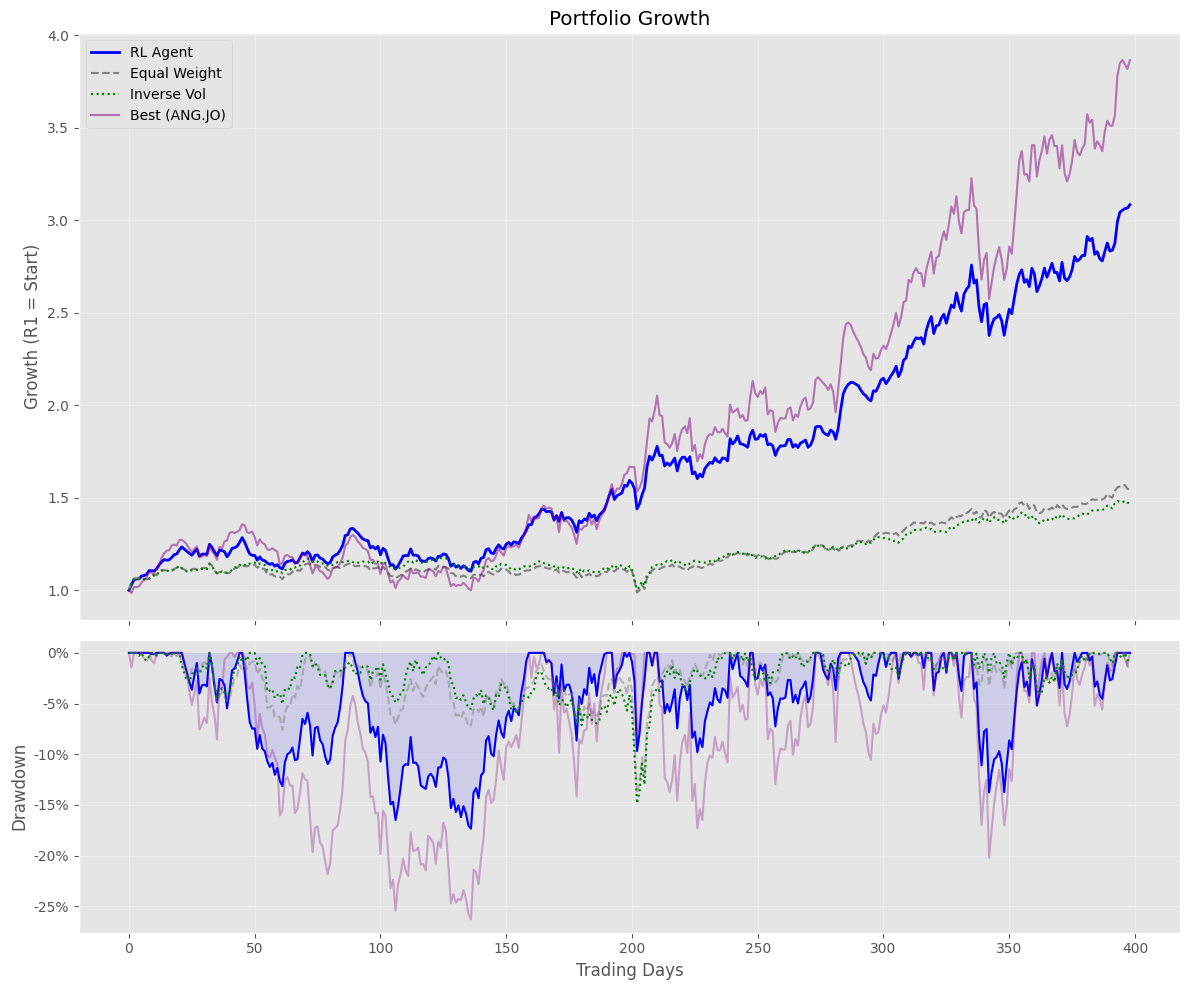

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from stable_baselines3 import DDPG
from stable_baselines3.common.vec_env import DummyVecEnv


total_len = len(stocks_ret)
val_end_idx = int(total_len * 0.8)

# Agent Test Data (Extended to allow the agent to see the 20 days of return prior to test period)
warmup = 20
test_start_idx = max(0, val_end_idx - warmup)

test_stock_extended = stocks_ret.iloc[test_start_idx:]
test_vol_extended = stocks_vol.iloc[test_start_idx:]
test_macro_extended = macro_ret.iloc[test_start_idx:]

# Benchmark Data 
full_vol = stocks_ret.rolling(window=20).std().shift(1).fillna(1e-6)
test_vol_aligned = full_vol.iloc[val_end_idx:]
test_stock_ret = stocks_ret.iloc[val_end_idx:]

print(f"Test Set Size: {len(test_stock_ret)} days")


def create_master_tearsheet(agent_values, test_stock_ret, test_vol_aligned, agent_std_dev=None):
    initial_value = 100000 
    # Align Lengths
    agent_curve = [initial_value] + agent_values

    # Ensure benchmark matches exactly
    n_days = len(agent_curve)
    # Slice returns and convert to linear returns
    stock_ret_slice = test_stock_ret.iloc[:n_days-1]
    stock_ret_linear = np.exp(stock_ret_slice) - 1
    days = range(n_days)

    # Benchmark Calculations 
    # Equal Weight
    ew_ret = stock_ret_linear.mean(axis=1)
    ew_curve = initial_value * (1 + ew_ret).cumprod()
    ew_curve = np.concatenate(([initial_value], ew_curve.values))

    # Best Single Stock
    cum_ret = (1 + stock_ret_linear).cumprod()
    best_name = cum_ret.iloc[-1].idxmax()
    best_curve = initial_value * cum_ret[best_name]
    best_curve = np.concatenate(([initial_value], best_curve.values))

    # Inverse Volatility (Risk Parity)
    # Look at volatility for previous 20 days and adjust weights so less volatile stocks are given more weight
    vol_slice = test_vol_aligned.iloc[:n_days-1]
    inv_vol = 1 / (vol_slice + 1e-6)
    weights = inv_vol.div(inv_vol.sum(axis=1), axis=0)
    
    iv_ret = (weights * stock_ret_linear).sum(axis=1)
    iv_curve = initial_value * (1 + iv_ret).cumprod()
    iv_curve = np.concatenate(([initial_value], iv_curve.values))

    def get_stats(curve, name):
        total_ret = curve[-1] / curve[0]
        n_years = len(curve) / 252
        cagr = (total_ret ** (1/n_years)) - 1 if n_years > 0 else 0
        
        series = pd.Series(curve)
        daily_ret = series.pct_change().dropna()
        ann_vol = daily_ret.std() * np.sqrt(252)
        sharpe = (daily_ret.mean() * 252) / (ann_vol + 1e-9)
        
        roll_max = series.cummax()
        dd = (series / roll_max) - 1
        max_dd = dd.min()
        
        return [name, cagr, ann_vol, sharpe, max_dd], dd

    agent_stats, agent_dd = get_stats(agent_curve, "RL Agent")
    ew_stats, ew_dd = get_stats(ew_curve, "Equal Weight")
    iv_stats, iv_dd = get_stats(iv_curve, "Inverse Vol")
    best_stats, best_dd = get_stats(best_curve, f"Best ({best_name})")

    # Display Table
    df = pd.DataFrame([agent_stats, ew_stats, iv_stats, best_stats], 
                      columns=["Strategy", "CAGR", "Vol", "Sharpe", "Max DD"])
    print("\n--- Performance Report ---")
    print(df.to_string(index=False, formatters={
        'CAGR': '{:.1%}'.format, 
        'Vol': '{:.1%}'.format, 
        'Sharpe': '{:.2f}'.format, 
        'Max DD': '{:.1%}'.format
    }))

    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    
    
    norm_agent = np.array(agent_curve)/initial_value
    ax1.plot(days, norm_agent, label='RL Agent', color='blue', linewidth=2)
    
    # Standard Error Bars (Shading)
    if agent_std_dev is not None:
        # Align: If std_dev doesn't include Day 0, prepend 0
        std_aligned = list(agent_std_dev)
        if len(std_aligned) == len(agent_values):
            std_aligned = [0.0] + std_aligned
        
        # Ensure exact length match
        std_aligned = std_aligned[:n_days]
        
        # Normalize to plot scale 
        norm_std = np.array(std_aligned) / initial_value
        
        ax1.fill_between(days, norm_agent - norm_std, norm_agent + norm_std, 
                         color='blue', alpha=0.15, label='Stability (±1 Std)')
    

    ax1.plot(days, ew_curve/initial_value, label='Equal Weight', color='grey', linestyle='--')
    ax1.plot(days, iv_curve/initial_value, label='Inverse Vol', color='green', linestyle=':')
    ax1.plot(days, best_curve/initial_value, label=f'Best ({best_name})', color='purple', alpha=0.5)
    ax1.set_ylabel("Growth (R1 = Start)")
    ax1.set_title("Portfolio Growth")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Drawdown
    ax2.plot(days, agent_dd, color='blue', linewidth=1.5)
    ax2.fill_between(days, agent_dd, 0, color='blue', alpha=0.1)
    ax2.plot(days, ew_dd, color='grey', linestyle='--', alpha=0.5)
    ax2.plot(days, best_dd, color='purple', alpha=0.3)
    ax2.plot(days, iv_dd, color='green', linestyle=':')
    
    ax2.set_ylabel("Drawdown")
    ax2.set_xlabel("Trading Days")
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels([f'{x:.0%}' for x in vals])
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("Loading Model...")
final_model = DDPG.load(os.path.join("./best_hpo_model/", "best_model.zip"))

test_env = DummyVecEnv([lambda: StockTradingEnv(test_stock_extended, test_vol_extended, test_macro_extended)])
obs = test_env.reset()
done = [False]
agent_values = []

print("Running Backtest...")
while not done[0]:
    action, _ = final_model.predict(obs, deterministic=True)
    obs, _, done, info = test_env.step(action)
    agent_values.append(info[0]['portfolio_value'])

print("Generating Tearsheet...")
create_master_tearsheet(agent_values, test_stock_ret, test_vol_aligned)

###  Statistical Validation (Block Bootstrap)

Asset prices follow an underlying probability distribution, and our historical data represents just one single realization of that distribution. The agent's performance could theoretically be due to a "lucky draw" of specific market conditions.

Ideally, we would fit a generative model to run Monte Carlo simulations on thousands of alternative price paths (too much work for a pet project). However, given the complexity of modeling market microstructure, we resort to a robust alternative: **Block Bootstrapping**.

**Methodology:**
We generate 10,000 synthetic market scenarios by resampling the agent's returns **with replacement**. This tests if the strategy's edge persists even in "unlucky" universes where favorable regimes occur less frequently than observed history.
* **Block Sampling:** We sample in **10-day blocks** (rather than single days) to preserve local volatility clustering and market momentum, ensuring the synthetic data remains realistic.
* **Hypothesis Test:** We build a probability distribution of the Sharpe Ratio. If the 95% Confidence Interval (CI) is strictly positive, we confirm the result is not random noise.

**Results:**
The analysis confirms the agent's skill is statistically significant:
* **Observed Sharpe:** 2.46
* **95% Confidence Interval:** $[0.87, 3.75]$
* **Conclusion:** Since the lower bound (0.87) is strictly positive, we reject the null hypothesis that the agent's returns are random noise with **>95% confidence**.

Running 10000 bootstrap simulations (Block Size: 10)...

--- BOOTSTRAP RESULTS ---
Observed Sharpe: 2.46
95% Conf. Interval: [0.87, 3.75]
Probability Sharpe > 0: 100.0%
Statistically Significant (95% CI is strictly positive).


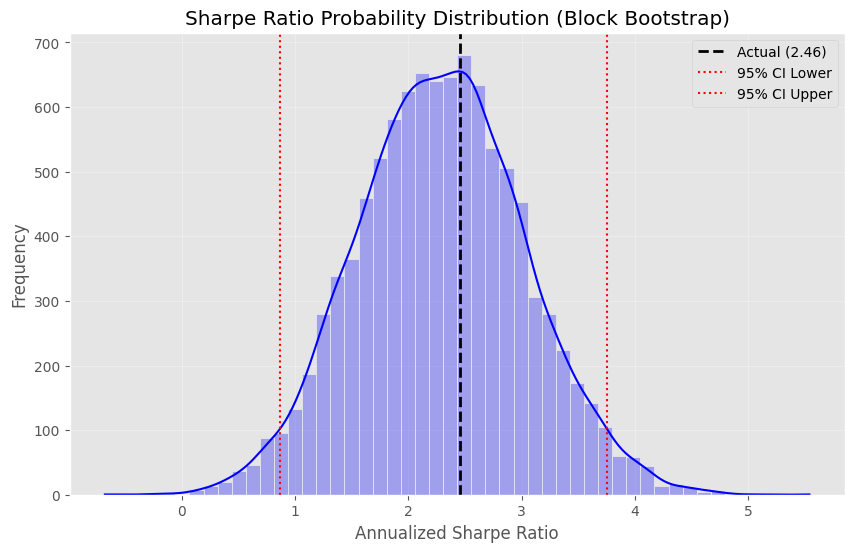

In [123]:
#Statistical Validation (Bootstrap)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def run_block_bootstrap(portfolio_values, n_samples=10000, block_size=10):
    """
    Resamples the agent's returns in chunks (blocks) to create synthetic histories.
    Preserves local volatility clustering while testing statistical significance.
    """
    portfolio_values = [100000] + list(portfolio_values)
    daily_returns = pd.Series(portfolio_values).pct_change().dropna().values
    n_days = len(daily_returns)
    sharpe_ratios = []
    
    print(f"Running {n_samples} bootstrap simulations (Block Size: {block_size})...")
    
    for _ in range(n_samples):
        # Generate a synthetic return series
        synthetic_returns = []
        while len(synthetic_returns) < n_days:
            # Pick a random starting point for a block
            start_idx = np.random.randint(0, n_days - block_size)
            # Grab the chunk
            block = daily_returns[start_idx : start_idx + block_size]
            synthetic_returns.extend(block)
        
        # Trim to exact original length
        synthetic_returns = np.array(synthetic_returns[:n_days])
        
        # Calculate Annualized Sharpe for this synthetic path
        ann_ret = np.mean(synthetic_returns) * 252
        ann_vol = np.std(synthetic_returns) * np.sqrt(252)
        sharpe = ann_ret / (ann_vol + 1e-9)
        sharpe_ratios.append(sharpe)

    
    sharpe_ratios = np.array(sharpe_ratios)
    actual_sharpe = (np.mean(daily_returns) * 252) / (np.std(daily_returns) * np.sqrt(252))
    
    lower_ci = np.percentile(sharpe_ratios, 2.5) # 95% Confidence Interval (Low)
    upper_ci = np.percentile(sharpe_ratios, 97.5) # 95% Confidence Interval (High)
    
    # Probability of Skill: % of simulations where Sharpe > 0 (or > Benchmark)
    prob_positive = np.sum(sharpe_ratios > 0) / n_samples
    
    print(f"\n--- BOOTSTRAP RESULTS ---")
    print(f"Observed Sharpe: {actual_sharpe:.2f}")
    print(f"95% Conf. Interval: [{lower_ci:.2f}, {upper_ci:.2f}]")
    print(f"Probability Sharpe > 0: {prob_positive*100:.1f}%")
    
    if lower_ci > 0:
        print("Statistically Significant (95% CI is strictly positive).")
    else:
        print("Result may be noise (CI crosses zero).")

    
    plt.figure(figsize=(10, 6))
    sns.histplot(sharpe_ratios, kde=True, color="blue", alpha=0.3, bins=50)
    
    
    plt.axvline(actual_sharpe, color='black', linestyle='--', linewidth=2, label=f'Actual ({actual_sharpe:.2f})')
    plt.axvline(lower_ci, color='red', linestyle=':', label='95% CI Lower')
    plt.axvline(upper_ci, color='red', linestyle=':', label='95% CI Upper')
    
    plt.title('Sharpe Ratio Probability Distribution (Block Bootstrap)')
    plt.xlabel('Annualized Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run it using the values from the previous cell
# Ensure 'agent_values' is available from backtest cell
if 'agent_values' in locals():
    run_block_bootstrap(agent_values)
else:
    print("Error: 'agent_values' not found. Please run previous cell first.")

### Interpretability & Explainable AI (XAI)

One of the most critical risks in using AI systems is the "Black Box" problem. Deep Reinforcement Learning agents (like DDPG) have no reasoning capabilities; they simply map states to probabilities based on reward signals. Blindly trusting a high Sharpe ratio without understanding the underlying drivers is dangerous, as I have no guarantee that the agent hasn't learned a spurious correlation or a reckless strategy.

To bridge this gap, I visualised the agent's asset allocation over the test period.

The stacked area chart below  reveals that the agent converged to a highly concentrated portfolio dominated by just three names: **AngloGold Ashanti (`ANG`)**, **Gold Fields (`GFI`)**, and **Capitec (`CPI`)**.

**Why this makes sense (The "Sanity Check"):**
* **The "Gold Rush":** The agent correctly identified the massive structural bull market in Gold, allocating heavily to `ANG` and `GFI`.
* **Sector Selection:** Instead of holding the entire banking index, it identified **Capitec** as the superior proxy for growth in the financial sector.
* **Structural Hedge:** As discussed in the Correlation analysis, holding *Miners* (Rand Hedges) alongside *Banks* (Domestic Cyclicals) provides a natural hedge against currency shocks. The agent effectively learned this macro-economic relationship from raw price data alone.

**The Hidden Risk:**
However, this also highlights a flaw in the agent's risk profile. Out of a universe of 12 stocks, it effectively ignored 9, concentrating 100% of its capital into just 3 equities. While this maximized returns during the backtest, it drastically increases **idiosyncratic risk** (risk tied to a specific company's failure). A human fund manager would likely enforce stricter diversification constraints to prevent such extreme concentration.

Running Allocation Analysis...


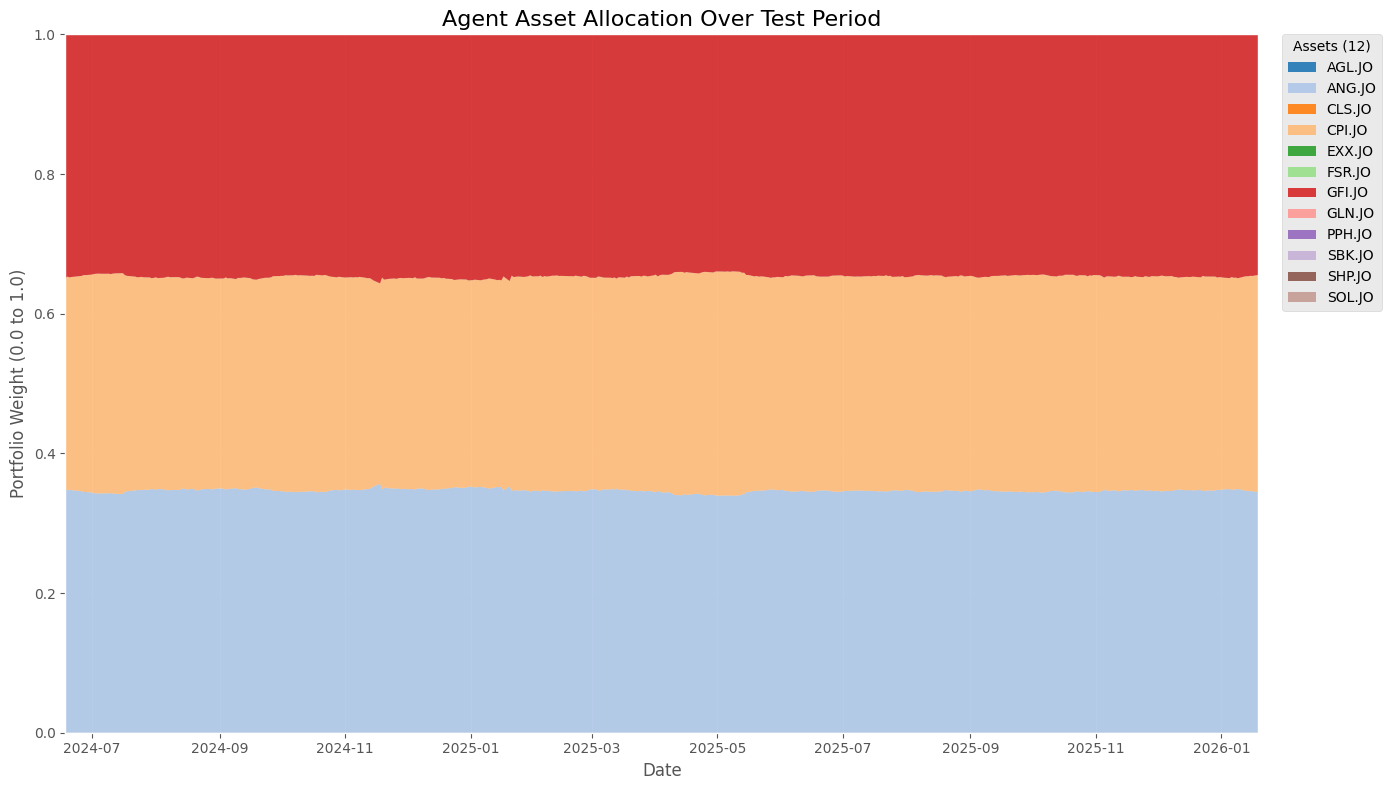

In [124]:
# Analyse agent's asset allocations over the test period
# Need to re-run the test episode to capture internal state (weights)
print("Running Allocation Analysis...")
# Reset test env to ensure clean start
obs = test_env.reset()
done = [False]
all_weights = []

def get_weights_from_action(action):
    exp_action = np.exp(action[0] * 5)
    return exp_action / np.sum(exp_action)

while not done[0]:
    action, _ = final_model.predict(obs, deterministic=True)
    weights = get_weights_from_action(action)
    all_weights.append(weights)
    obs, _, done, _ = test_env.step(action)


stock_names = test_stock_extended.columns
df_weights = pd.DataFrame(all_weights, columns=stock_names)
n_days = len(df_weights)
test_dates = test_stock_ret.index[:n_days]
df_weights.index = test_dates


plt.figure(figsize=(14, 8))
n_assets = len(df_weights.columns)
cmap = plt.get_cmap('tab20')
distinct_colors = [cmap(i) for i in range(n_assets)]

plt.stackplot(df_weights.index, df_weights.T, labels=df_weights.columns,
              colors=distinct_colors, alpha=0.9)

# Styling
plt.title("Agent Asset Allocation Over Test Period", fontsize=16)
plt.ylabel("Portfolio Weight (0.0 to 1.0)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.margins(0, 0) # Remove white space on edges
plt.ylim(0, 1.0)

# Move legend outside to keep chart clean
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1),
           title=f"Assets ({n_assets})", borderaxespad=0.)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Robustness Analysis: Sensitivity to Initial Conditions

A major challenge in deploying Deep Reinforcement Learning is its **Sensitivity to Random Initialization**. Because DDPG relies on random variables, specifically the initial weights of the neural network and the exploration noise process, two agents trained with identical hyperparameters can yield vastly different trading behaviors.

To investigate this, I performed a Robustness Check by re-training the agent 5 separate times using independent random starting states.

**Results Analysis:**
* **The "Lucky" Outlier:** In our initial single-run test (in the backtest cell above), I observed a massive **103% CAGR**.
* **The Average Reality:** When averaged across 5 independent runs, the agent's performance drops to **31.0%**, essentially converging to the Equal Weight benchmark (31.7%).


**Critical Conclusion:**
This experiment highlights a significant risk: **Lack of Reproducibility**.
While the agent *has the capacity* to significantly outperform (as seen in the isolated 103% run), it fails to do so consistently. On average, the complex deep learning model failed to beat the naive $1/N$ heuristic. This proves that the stellar results seen earlier were likely due to a "lucky draw" in the initialization parameters rather than a stable, repeatable market edge.

Loaded Best Params: {'learning_rate': 1.1234379911655835e-05, 'batch_size': 256, 'buffer_size': 100000, 'tau': 0.023392645658027896, 'gamma': 0.9, 'net_arch': 'small'}

---Starting Robustness Check (5 Seeds) ---

Training Seed 2042...


c:\Users\temi0\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Seed 2042 Final Return: 54.63%

Training Seed 2043...
Seed 2043 Final Return: 42.24%

Training Seed 2044...
Seed 2044 Final Return: 67.78%

Training Seed 2045...
Seed 2045 Final Return: 49.87%

Training Seed 2046...
Seed 2046 Final Return: 52.61%

--- Generating Master Tearsheet ---

--- Performance Report ---
     Strategy   CAGR   Vol Sharpe Max DD
     RL Agent  31.0% 16.8%   1.70 -14.1%
 Equal Weight  31.7% 17.0%   1.71 -13.9%
  Inverse Vol  27.6% 15.7%   1.64 -14.9%
Best (ANG.JO) 134.9% 45.2%   2.12 -26.3%


C:\Users\temi0\AppData\Local\Temp\ipykernel_8160\2911753991.py:137: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f'{x:.0%}' for x in vals])


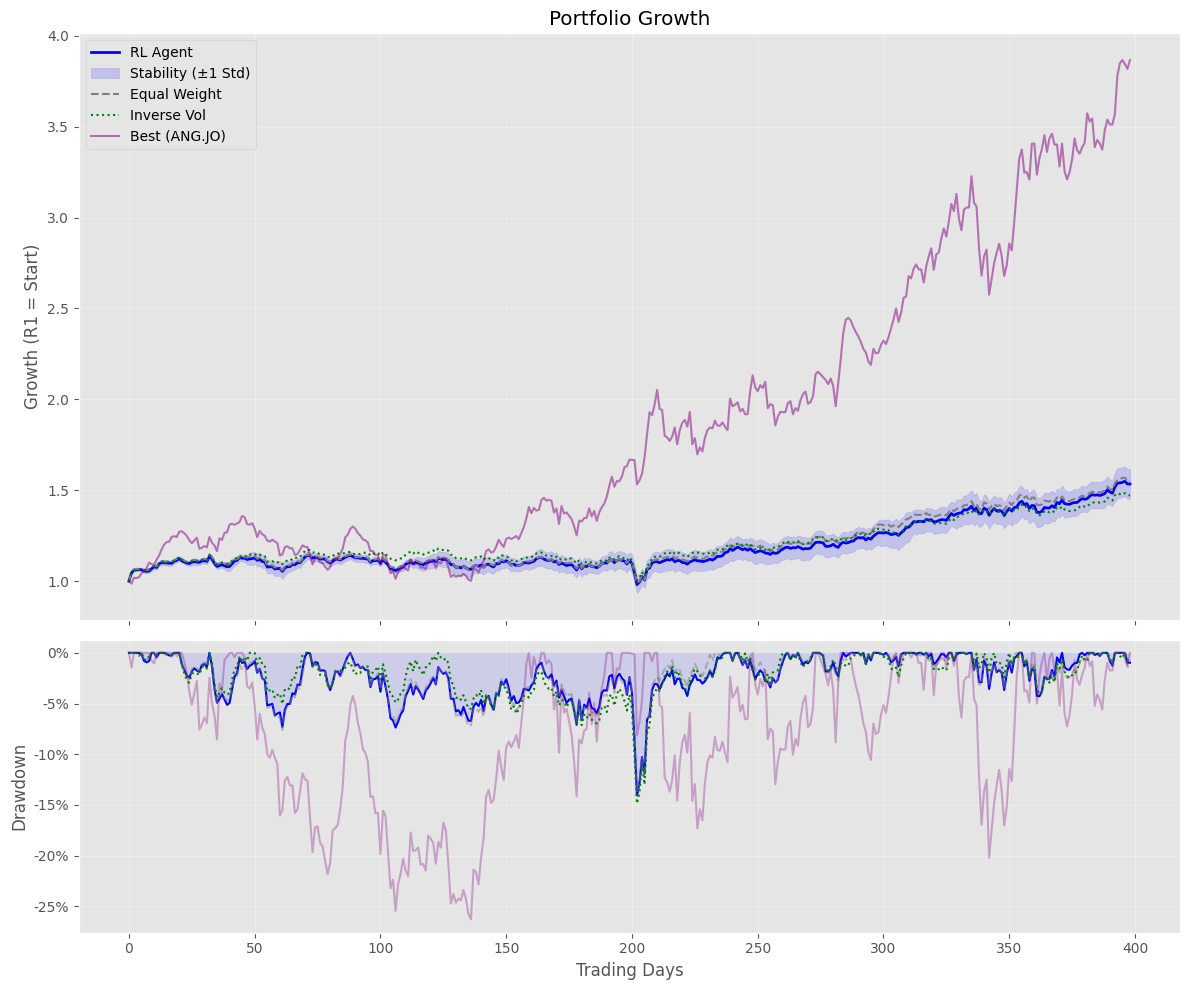

In [127]:
import ast
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement

# Load best hyperparameters
param_path = "./best_hpo_model/best_params.txt"
default_params = {
    'learning_rate': 1e-4, 
    'batch_size': 128, 
    'buffer_size': 100000, 
    'tau': 0.005, 
    'gamma': 0.99, 
    'net_arch': 'medium'
}

try:
    with open(param_path, "r") as f:
        content = f.read()
        # Extract the dictionary part safely
        dict_str = content.split("}")[0] + "}" 
        best_params = ast.literal_eval(dict_str)
        print("Loaded Best Params:", best_params)
except Exception as e:
    print(f" Could not load params ({e}). Using defaults.")
    best_params = default_params

# Map 'net_arch' string back to list
if best_params.get('net_arch') == 'medium':
    net_arch = [256, 256]
elif best_params.get('net_arch') == 'small':
    net_arch = [64, 64]
else:
    net_arch = [256, 256]


total_len = len(stocks_ret)
train_end = int(total_len * 0.70)
val_end = int(total_len * 0.80)

# Training Data
train_stock = stocks_ret.iloc[:train_end]
train_vol = stocks_vol.iloc[:train_end]
train_macro = macro_ret.iloc[:train_end]

# Validation Data (Strictly for Early Stopping)
val_stock = stocks_ret.iloc[train_end:val_end]
val_vol = stocks_vol.iloc[train_end:val_end]
val_macro = macro_ret.iloc[train_end:val_end]

# Test Data 
warmup = 20
test_start_idx = max(0, val_end - warmup)

test_stock_extended = stocks_ret.iloc[test_start_idx:]
test_vol_extended = stocks_vol.iloc[test_start_idx:]
test_macro_extended = macro_ret.iloc[test_start_idx:]

# Data for Benchmarks 
test_stock_ret = stocks_ret.iloc[val_end:]
# Full volatility history aligned to test start (prevents NaN start in benchmarks)
full_vol = stocks_ret.rolling(window=20).std().shift(1).fillna(1e-6)
test_vol_aligned = full_vol.iloc[val_end:]

# Robustness check with 5 seeds
seeds = [2042, 2043, 2044, 2045, 2046]
all_portfolio_values = []
initial_balance = 100000

print(f"\n---Starting Robustness Check (5 Seeds) ---")

for seed in seeds:
    print(f"\nTraining Seed {seed}...")
    
    # Setup Environments (Re-create to reset states)
    env_train = DummyVecEnv([lambda: StockTradingEnv(train_stock, train_vol, train_macro)])
    env_val = DummyVecEnv([lambda: StockTradingEnv(val_stock, val_vol, val_macro)])
    env_test = DummyVecEnv([lambda: StockTradingEnv(test_stock_extended, test_vol_extended, test_macro_extended)])
    
    # Callbacks (Early Stopping)
    seed_path = f"./robustness_check/seed_{seed}"
    os.makedirs(seed_path, exist_ok=True)
    
    stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
    eval_callback = EvalCallback(env_val, 
                                 best_model_save_path=seed_path,
                                 callback_after_eval=stop_train_callback,
                                 eval_freq=1000, 
                                 n_eval_episodes=3,
                                 deterministic=True, 
                                 verbose=0)
    
    # Initialize Agent
    n_actions = env_train.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    
    model = DDPG("MlpPolicy",
                 env_train,
                 learning_rate=best_params['learning_rate'],
                 batch_size=best_params['batch_size'],
                 buffer_size=best_params['buffer_size'],
                 tau=best_params['tau'],
                 gamma=best_params['gamma'],
                 policy_kwargs=dict(net_arch=dict(pi=net_arch, qf=net_arch)),
                 action_noise=action_noise,
                 seed=seed,
                 verbose=0)
    
    # Train
    model.learn(total_timesteps=20000, callback=eval_callback)
    
    # Load Best Model & Backtest
    best_model = DDPG.load(os.path.join(seed_path, "best_model"))
    
    obs = env_test.reset()
    done = [False]
    seed_values = []
    
    while not done[0]:
        action, _ = best_model.predict(obs, deterministic=True)
        obs, _, done, info = env_test.step(action)
        seed_values.append(info[0]['portfolio_value'])
        
    all_portfolio_values.append(seed_values)
    
    final_ret = (seed_values[-1] - initial_balance) / initial_balance
    print(f"Seed {seed} Final Return: {final_ret*100:.2f}%")


print("\n--- Generating Master Tearsheet ---")

# Align all runs (Truncate to shortest length for safety)
min_len = min(len(v) for v in all_portfolio_values)
aligned_runs = [v[:min_len] for v in all_portfolio_values]

# Calculate Mean and Std Dev across 5 seeds
mean_values = np.mean(aligned_runs, axis=0)
std_values = np.std(aligned_runs, axis=0)


create_master_tearsheet(
    agent_values=mean_values.tolist(), 
    test_stock_ret=test_stock_ret, 
    test_vol_aligned=test_vol_aligned,
    agent_std_dev=std_values.tolist()
)

### 8. Conclusion: Strengths, Weaknesses & Final Verdict

This project demonstrated the potential and pitfalls of Deep Reinforcement Learning in South African equities. While the agent showed flashes of brilliance, rigorous validation revealed significant deployment risks.

#### ** Strengths**
* **Macro-Regime Detection:** The agent correctly identified the "Gold Super-Cycle," identifying AngloGold Ashanti and Gold Fields as high-conviction plays.
* **Cost Efficiency:** The DDPG agent learned to minimize transaction costs (0.1%), effectively discovering a "Buy and Hold" strategy for winners.
* **High Upside:** In its best configuration, the agent achieved a **Sharpe Ratio of 2.45** and **103% Return**, proving the neural network can discover  strategies that vastly outperform the market.

#### ** Weaknesses**
* **Instability (The "Lucky Seed" Problem):** The agent is highly sensitive to initialization. While one seed generated 103%, the average across 5 runs was only **31%**, effectively matching the benchmark.
* **Concentration Risk:** To maximize the Sharpe Ratio, the agent concentrated 100% of capital into just 3 stocks. This exposes the portfolio to massive idiosyncratic risk
* **Selection Bias:** The agent operated on a human-curated universe of 12 large cap stocks. It does not have the ability to autonomously filter quality assets from the broader, noisier JSE.

#### **Final Verdict**
Would I give this agent real money and trade live? Definitely not. More work needs to be done. Firstly, I think that ensemble learning (training multiple agents at once and averaging results) may help with robustness issues. Secondly, by constraining the outputs of the agent during training we can force it to produce more diverse portfolios. Lastly, it might be a good idea to add a script where we prompt an LLM to find good stock picks to add to our universe. If I find the time I'll update the repo😉.